In [10]:
#!module load cuda

/bin/bash: line 1: module: command not found


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm, trange

from datetime import datetime, timedelta

In [12]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/big_arpafvg.csv', img_dir = 'data/images'):
        initial_data=pd.read_csv(weather_data)
        initial_data = initial_data.drop(columns=['Temp. min gradi C','Temp. med gradi C','Temp. max gradi C','Vento med km/h','Dir. V. max gradi N'])
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.img_dir = img_dir
        self.seq_length = 7
        self.target_column_index = 3
        self.date_generated = []

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0])

        image = os.path.join(self.img_dir, str(date) + '.jpg')  
        image = read_image(image)   
        return [image, weather_data]
    
    def __len__(self):
        return len(self.weather_data)
    '''
    def create_sequences(self, data):
        xs, ys, imgs = [], [], []
        for i in range(len(data) - self.seq_length-1):
            x = data[i:i+self.seq_length]
            y = data[i+self.seq_length+1, self.target_column_index]
            img_path = os.path.join(self.img_dir,str(x[2]) + '_' + str(x[1]) + '_'+ (x[0]) + '.jpg')
            img= read_image(img_path)
            xs.append(x)
            ys.append(y)
            imgs.append(img)
        return np.array(xs), np.array(ys)
    '''

    def date_generation(self, start_date, end_date):
        start_date = datetime.strptime(start_date, "%d_%m_%Y")
        end_date = datetime.strptime(end_date, "%d_%m_%Y")
        date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
        #transform the list of datetime objects in a list of strings in format dd-mm-yyyy
        date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]
        self.date_generated=date_generated
        return date_generated
    
    def create_sequences(self, len_seq):
        xs, ys, imgs = [], [], []
        for date in self.date_generated:
            end_of_week = date.split('_')
            end_of_week = datetime(int(end_of_week[2]), int(end_of_week[1]), int(end_of_week[0])) + timedelta(days = len_seq)
            end_of_week = end_of_week.strftime("%d_%m_%Y")


            week=self.date_generation(date, end_of_week)
            img, x =[], []
            for day in week:
                a , b = self.__getitem__(day)
                img.append(a)
                x.append(b)
            imgs.append(img)
            xs.append(x)

            next = end_of_week.split('_')
            next = datetime(int(next[2]), int(next[1]), int(next[0])) + timedelta(days = 1)
            next = next.strftime("%d_%m_%Y")
            ys.append(self.__getitem__(next)[1][self.target_column_index])
        return imgs, xs, ys

In [13]:
dataset = WeatherDataset()

In [14]:
#generate a list of strings dd-mm-yyyy from 01-06-2023 to 15-6-2024
dataset.date_generation("01_06_2024", "15_06_2024")
imgs, xs, ys = dataset.create_sequences(7)  


KeyboardInterrupt: 

In [ ]:
train_len = int(0.8 * len(dataset.date_generated))
test_len = len(dataset.date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
xs_train=xs[:train_len]
xs_test=xs[train_len:]
ys_train=ys[:train_len]
ys_test=ys[train_len:]
imgs_train=imgs[:train_len]
imgs_test=imgs[train_len:]

In [ ]:
class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3), stride = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3), stride = 1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), stride = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), stride = 1)
        self.bn6 = nn.BatchNorm2d(256)

        self.input_size = 9226
        self.hidden_size = 16
        self.num_layers = 2
        self.output_size = 1
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x1, x2):        

        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = self.bn4(self.dropout(self.pool(F.leaky_relu(self.conv4(x1)))))
        x1 = self.bn5(self.dropout(self.pool(F.leaky_relu(self.conv5(x1)))))
        x1 = self.bn6(self.dropout(self.pool(F.leaky_relu(self.conv6(x1)))))
        x1 = torch.flatten(x1, start_dim = 1)

        x = torch.cat((x1, x2), dim = 1)
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)

        return x

In [ ]:
def train(model, dataset, batch_size, xs_trainloader, xs_testloader, imgs_trainloader, imgs_testloader, ys_trainloader, ys_testloader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    train_loss_epochs = []
    test_loss_epochs = []
    bar = trange(epochs, desc=f"Epoch ?/?, Train Loss: ?, Test Loss: ?")
    for epoch in bar:
        model.train()
        train_losses = []
        for img, xs, ys in zip(imgs_trainloader, xs_trainloader, ys_trainloader):
            optimizer.zero_grad()
            outputs = model(img, xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for ims, xs, ys in zip(imgs_testloader, xs_testloader, ys_testloader):
                outputs = model(imgs, xs)
                loss = criterion(outputs.squeeze(), ys)
                test_losses.append(loss.item())
                
        test_loss_epochs.append(np.mean(test_losses))
        bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")
        #if first_time:
            #torch.save(model.state_dict(), f"deepweather_epoch{num_saved_epochs + epoch + 1}.pth")

    return train_loss_epochs, test_loss_epochs

In [ ]:
#Uncomment the lines below if you want to train/load a pretrained model
#num_saved_epochs = 50
#model = model.load_state_dict(torch.load(f'weights/epoch_{num_saved_epochs}'))

#Comment the (ONE) line below if you want to train/load a pretrained model.
#!mkdir weights
model = DeepWeather()
batch_size = 4
xs_trainloader = DataLoader(xs_train, batch_size = batch_size, shuffle = False)
xs_testloader = DataLoader(xs_test, batch_size = batch_size, shuffle = False)

imgs_trainloader = DataLoader(imgs_train, batch_size = batch_size, shuffle = False)
imgs_testloader = DataLoader(imgs_test, batch_size = batch_size, shuffle = False)

ys_trainloader = DataLoader(ys_train, batch_size = batch_size, shuffle = False)
ys_testloader = DataLoader(ys_test, batch_size = batch_size, shuffle = False)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 10e-6, momentum = 0)

In [ ]:
train_losses, val_losses = train(model, dataset, batch_size, xs_trainloader, xs_testloader, imgs_trainloader, imgs_testloader, ys_trainloader, ys_testloader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0)

Epoch ?/?, Train Loss: ?, Test Loss: ?:   0%|                                                    | 0/50 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([9226])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50/50, Train Loss: 445.44099183322334, Test Loss: 445.5333143446181: 100%|████████| 50/50 [05:12<00:00,  6.24s/it]


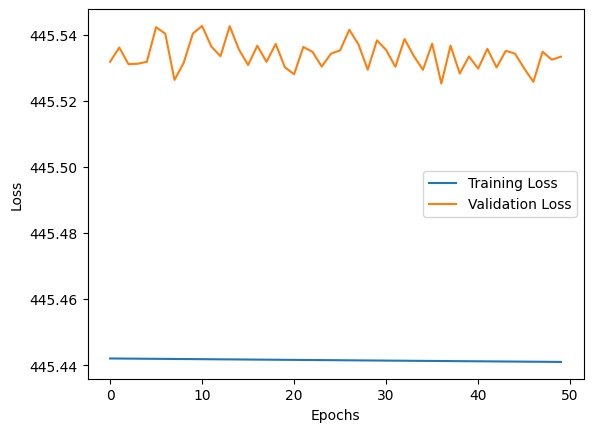

In [ ]:
epochs = [epoch for epoch in range(50)]
plt.plot(epochs, train_losses, label = 'Training Loss')
plt.plot(epochs, val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def predict(model, date):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    inputs = dataset[date]
    inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

    outputs = model(inputs)    
    
    return outputs

In [ ]:
print(predict(model, '31_12_2023'))
print(dataset['31_12_2023'][1][3])

tensor([[-0.9158, -0.9157, -0.9158,  ...,  0.0099, -1.4641, -0.0677]],
       device='cuda:0', grad_fn=<CatBackward0>)
tensor(-0.1916, dtype=torch.float64)


In [ ]:
for date in date_testset:
    predicted_rain = predict(model, date)
    #non normalized results
    predicted_rain = predicted_rain 
    print(f"Predicted rain normalized for {date} is {predicted_rain}")
    #while real rain is
    print(f"Real rain normalized  for {date} is {dataset[date][1][3]}")   


Predicted rain normalized for 18_12_2023 is tensor([[-0.9151, -0.9150, -0.9148,  ..., -1.3190, -0.9106,  2.2002]],
       device='cuda:0', grad_fn=<CatBackward0>)
Real rain normalized  for 18_12_2023 is -0.32236044818546217
Predicted rain normalized for 19_12_2023 is tensor([[-0.9152, -0.9150, -0.9150,  ..., -1.2360, -0.8078,  1.0848]],
       device='cuda:0', grad_fn=<CatBackward0>)
Real rain normalized  for 19_12_2023 is -0.32236044818546217
Predicted rain normalized for 20_12_2023 is tensor([[-0.9162, -0.9158, -0.9151,  ..., -0.2808, -1.2210, -0.2165]],
       device='cuda:0', grad_fn=<CatBackward0>)
Real rain normalized  for 20_12_2023 is -0.32236044818546217
Predicted rain normalized for 21_12_2023 is tensor([[-0.9149, -0.9145, -0.9150,  ..., -0.2808, -1.0008, -0.9848]],
       device='cuda:0', grad_fn=<CatBackward0>)
Real rain normalized  for 21_12_2023 is -0.32236044818546217
Predicted rain normalized for 22_12_2023 is tensor([[-0.9150, -0.9146, -0.9145,  ..., -0.4470, -0.9007, 